#             Amazon Food Reviews - [Naive Bayes]


In [13]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

con = sqlite3.connect('preprocessed.sqlite')#Loading the data set which was saved after peforming preprocessing steps in k-nn 


data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con) 

In [14]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [15]:
data.shape

(364171, 12)

In [16]:
def polarity(X):
    if X=='positive':
        return 1
    else:
        return 0
data["Score"]=data["Score"].map(polarity)
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [17]:
data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [18]:
data.sort_values('Time',inplace=True)
data.head(5)
#Splitting on time based

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


# Bag Of Words(BOW)

In [22]:
#%%pixie_debugger
#import pixiedust
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.model_selection import train_test_split


#Splitting the data in o train and test data sets
X_train, X_test, y_train, y_test=train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,random_state=0)


count_vect = CountVectorizer() 
X_train = count_vect.fit_transform(X_train)
print(X_train.shape)
print(type(X_train))


X_test=count_vect.transform(X_test)
print(X_test.shape)
print(type(X_test))


(254919, 59640)
<class 'scipy.sparse.csr.csr_matrix'>
(109252, 59640)
<class 'scipy.sparse.csr.csr_matrix'>


In [23]:
#Normalizing the data
from sklearn import preprocessing

X_train=preprocessing.normalize(X_train)
print(X_train.shape)

X_test=preprocessing.normalize(X_test)
print(X_test.shape)


print(type(X_test.shape))

(254919, 59640)
(109252, 59640)
<class 'tuple'>


# BERNOULLI NAIVE BAYES

In [24]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #Hyperparamter(aplha) tuning through CV
gsv = GridSearchCV(bnb,param_grid,cv=10,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.4min finished


Best HyperParameter:  {'alpha': 0.01}
Best Accuracy: 88.99%


Accuracy on test set: 89.222%
Precision on test set: 0.933
Recall on test set: 0.940
F1-Score on test set: 0.936
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



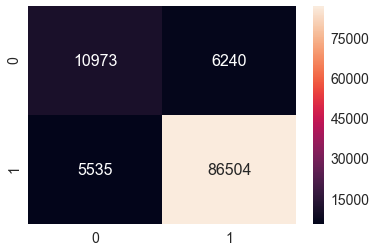

In [26]:
#Testing Accuracy on Test data

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import BernoulliNB


bnb = BernoulliNB(alpha=0.01)
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# MULTINOMIAL NAIVE_BAYES

In [32]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} 
gsv = GridSearchCV(mnb,param_grid,cv=10,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best HyperParameter:  {'alpha': 0.005}
Best Accuracy: 87.43%


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   54.7s finished


Accuracy on test set: 87.187%
Precision on test set: 0.870
Recall on test set: 0.997
F1-Score on test set: 0.929
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



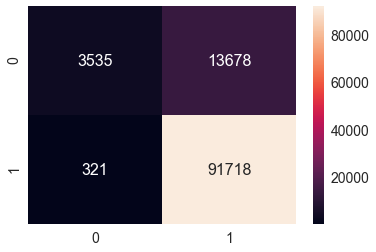

In [33]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=0.005)
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Important Features for each class

In [36]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vect,bnb)

			Positive						Negative
________________________________________________________________________________________________
	-17.5768	aaaaaahhhhh    				-1.1763	like           
	-17.5768	aaaaaahhhhhyaaaaaa				-1.2032	tast           
	-17.5768	aachen         				-1.2608	love           
	-17.5768	aappubl        				-1.2672	good           
	-17.5768	aargh          				-1.2950	great          
	-17.5768	aarrgh         				-1.4288	flavor         
	-17.5768	aauc           				-1.4678	one            
	-17.5768	abhorr         				-1.4759	use            
	-17.5768	ablet          				-1.5250	tri            
	-17.5768	abolitionist   				-1.5375	product        
	-17.5768	abort          				-1.6571	make           
	-17.5768	abottl         				-1.6888	get            
	-17.5768	abov           				-1.8910	buy            
	-17.5768	abovi          				-1.8996	time           
	-17.5768	abrevi         				-1.9307	would          
	-17.5768	absoprt        				-1.9690	realli         
	-17.5768	absoslut       	

# TF-IDF

In [37]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer() 
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (254919, 59198)
Test Data Size:  (109252, 59198)
Wall time: 16.3 s


# BERNOULLI NAIVE BAYES

In [38]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
gsv = GridSearchCV(bnb,param_grid,cv=10,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.4min finished


Best HyperParameter:  {'alpha': 0.005}
Best Accuracy: 89.06%


Accuracy on test set: 88.343%
Precision on test set: 0.926
Recall on test set: 0.933
F1-Score on test set: 0.930
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



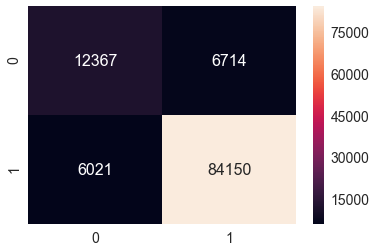

In [40]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB(alpha=0.005)
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# MULTINOMIAL NAIVE BAYES

In [41]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
gsv = GridSearchCV(mnb,param_grid,cv=10,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best HyperParameter:  {'alpha': 0.05}
Best Accuracy: 88.25%


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   53.0s finished


Accuracy on test set: 86.417%
Precision on test set: 0.863
Recall on test set: 0.993
F1-Score on test set: 0.923
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



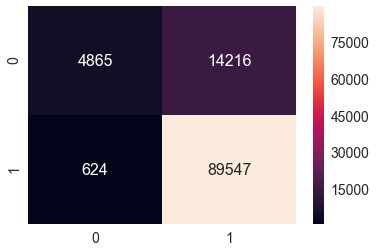

In [42]:

#Testing Accuracy on Test data
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=0.05)
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# IMPORTANT FEATURES FOR EACH CLASS

In [43]:

def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("___________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf,bnb)

			Positive						Negative
________________________________________________________________________________________________
	-17.5855	aaaaaaarrrrrggghhh				-1.1898	like           
	-17.5855	aaaaaahhhhhyaaaaaa				-1.2078	tast           
	-17.5855	aachen         				-1.2728	love           
	-17.5855	aarrgh         				-1.2770	good           
	-17.5855	aauc           				-1.2940	great          
	-17.5855	abalon         				-1.4290	flavor         
	-17.5855	abbazabba      				-1.4724	one            
	-17.5855	abiet          				-1.4907	use            
	-17.5855	abolitionist   				-1.5344	tri            
	-17.5855	abort          				-1.5642	product        
	-17.5855	abottl         				-1.6464	make           
	-17.5855	abrevi         				-1.6961	get            
	-17.5855	abrotanum      				-1.9062	buy            
	-17.5855	absolutelt     				-1.9097	time           
	-17.5855	absoprt        				-1.9481	amazon         
	-17.5855	absurt         				-1.9581	would          
	-17.5855	abswer       

# Model Performance 

# Conclusion

1) Naive Bayes with 50k points took very less time to train the model compared to k-nn

2) Naive Bayes don't work well with AVG-W2V and tf-idf_w2v as features are completely dependent

3) Best accuracy of 89.222% is acheived through Bernoulli NB in BOW.

Note: Naive Bayes hold the assumption of Feature independence